Carryover and Shape Effects in Media Mix Modeling: Paper Review
From https://towardsdatascience.com/carryover-and-shape-effects-in-media-mix-modeling-paper-review-fd699b509e2d

In [ ]:
import numpy as np
import pandas
import arviz as az
import pymc3 as pm
import plotly.express as px
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal as signal

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Define some functions to model media carryover and shape

In [ ]:
def geoDecay(alpha, L):
    '''
    weighted average with geometric decay
    weight_T = alpha ^ T-1 
    returns: weights of length L to calculate weighted averages with. 
    '''
    return alpha**(np.ones(L).cumsum()-1)

def delayed_adstock(alpha, theta, L):
    '''
    weighted average with dealyed adstock function
    weight_T = 
    returns: weights of length L to calculate weighted averages with. 
    '''
    return alpha**((np.ones(L).cumsum()-1)-theta)**2

def carryover(x, alpha, L, theta = None, func='geo'):
    '''
    1. x is a vector of media spend going back L timeslots, so it should be len(x) == L
    2. Weights is a vector of length L showing how much previous time periods spend has on current period. 
    3. L is max length of Lag.
    returns transformed vector of spend
    # update with numpy average 
    # np.average(x[:2], weights=[1,.9])
    '''
    transformed_x = []
    if func=='geo':
        weights = geoDecay(alpha, L)
        
    elif func=='delayed':
        weights = delayed_adstock(alpha, theta, L)
    
    for t in range(x.shape[0]):
        upper_window = t+1
        lower_window = max(0,upper_window-L)
        current_window_x = x[:upper_window]
        t_in_window = len(current_window_x)
        if t < L:
            new_x = (current_window_x*np.flip(weights[:t_in_window], axis=0)).sum()
            transformed_x.append(new_x/weights[:t_in_window].sum())
        elif t >= L:
            current_window_x = x[upper_window-L:upper_window]
            ext_weights = np.flip(weights, axis=0) 
            new_x = (current_window_x*ext_weights).sum()
            transformed_x.append(new_x/ext_weights.sum())
            
    return np.array(transformed_x)

def beta_hill(x, S, K, beta):
    return beta - (K**S*beta)/(x**S+K**S)

Look at these functions for a few different choices and parameters

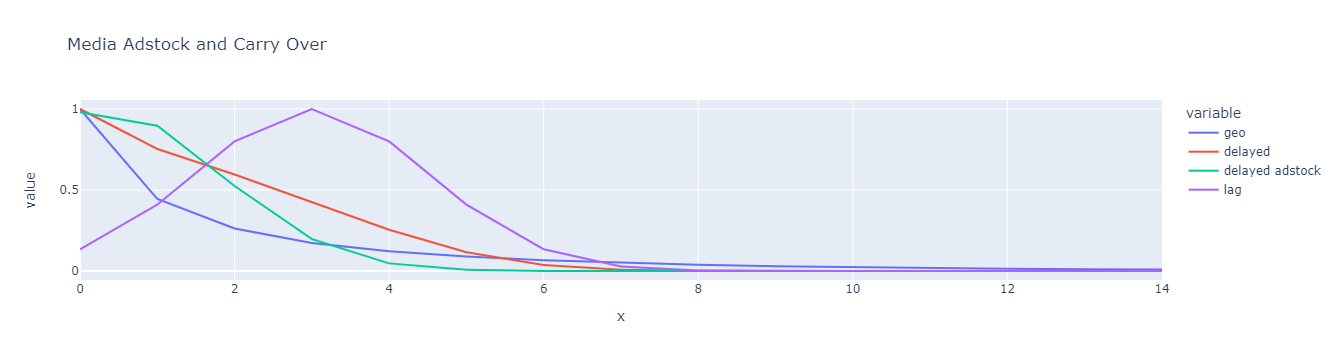

In [ ]:
L = 15
x = range(L)
media = np.zeros(L)
media[0] = 1
media = np.array(media)
df = pandas.DataFrame()
df['x'] = x
df['geo'] = carryover(media, .8, L, 3, 'geo')
df['delayed'] = carryover(media, .8, L, 3, func='delayed')
df['delayed adstock'] = delayed_adstock(.8, .3, L)
df['lag'] = .8**((np.ones(L).cumsum()-1)-3)**2
fig = px.line(df, x="x", y=['geo', 'delayed', 'delayed adstock', 'lag'], 
              title='Media Adstock and Carry Over')
fig.show()

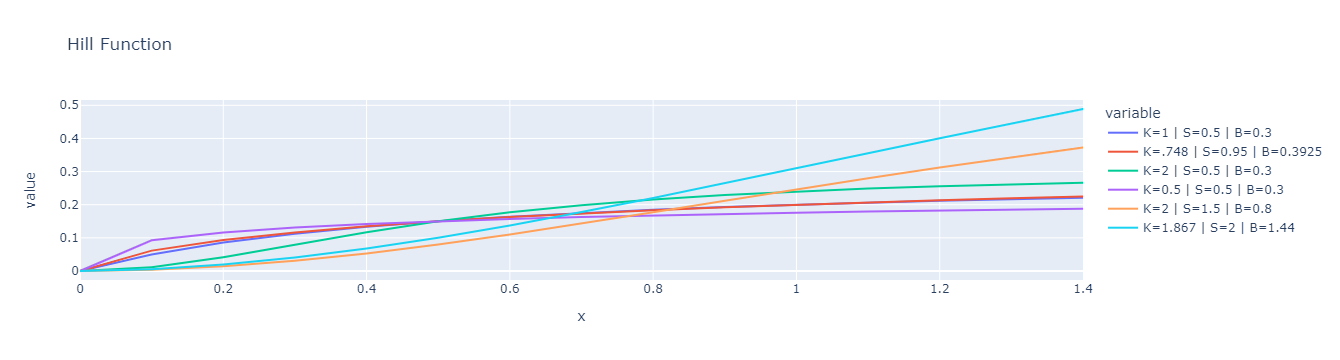

In [ ]:
L = 15
x = [float(x)/10.0 for x in range(L)]
df = pandas.DataFrame()
df['x'] = x
df['K=1 | S=0.5 | B=0.3'] = [beta_hill(i, 1, 0.5, 0.3) for i in x]
df['K=.748 | S=0.95 | B=0.3925'] = [beta_hill(i, .748, .95, .3925) for i in x]
df['K=2 | S=0.5 | B=0.3'] = [beta_hill(i, 2, 0.5, 0.3) for i in x]
df['K=0.5 | S=0.5 | B=0.3'] = [beta_hill(i, 0.5, 0.5, 0.3) for i in x]
df['K=2 | S=1.5 | B=0.8'] = [beta_hill(i, 2, 1.5, 0.8) for i in x]
df['K=1.867 | S=2 | B=1.44'] = [beta_hill(i, 1.867, 2, 1.44) for i in x]
y =['K=1 | S=0.5 | B=0.3', 'K=.748 | S=0.95 | B=0.3925', 'K=2 | S=0.5 | B=0.3',
   'K=0.5 | S=0.5 | B=0.3', 'K=2 | S=1.5 | B=0.8', 'K=1.867 | S=2 | B=1.44']
fig = px.line(df, x="x", y=y, title='Hill Function')
fig.show()

Model a campaign with 3 media sources and a price variable using the functions above and calculate return

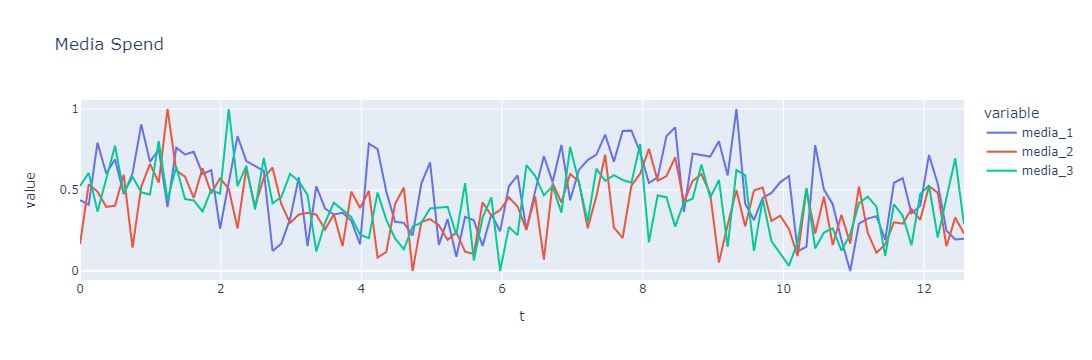

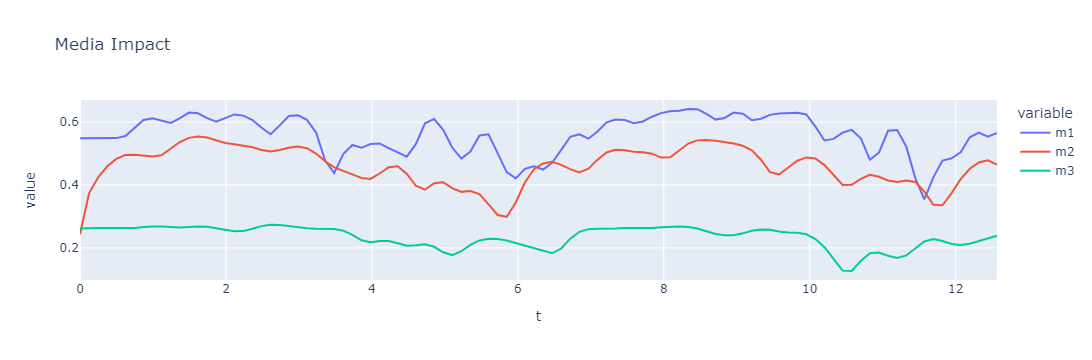

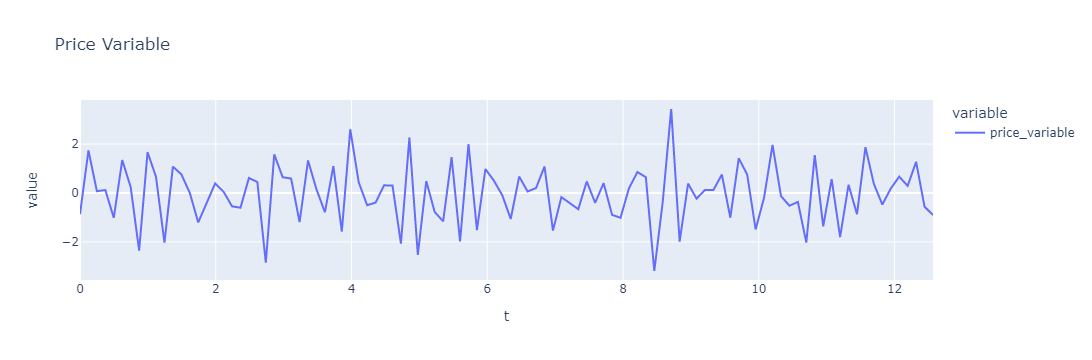

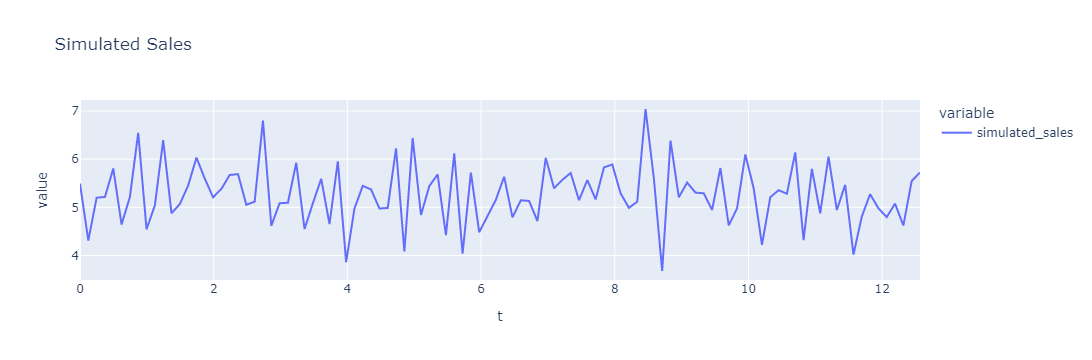

In [ ]:
# media channels 
N = 102 # number of data points
t = np.linspace(0, 4*np.pi, N)
data = 3+np.sin(t+0.001) + 0.5 + np.random.randn(N)
media_1 = ((data-min(data))/(max(data)-min(data)) ) 

t = np.linspace(0, 4*np.pi, N)
data = 3+np.sin(t+0.001) + 0.5 + np.random.randn(N)
media_2 = ((data-min(data))/(max(data)-min(data)) )  

t = np.linspace(0, 4*np.pi, N)
data = 3+np.sin(t+0.001) + 0.5 + np.random.randn(N)
media_3 = ((data-min(data))/(max(data)-min(data)) )  

# price 
from statsmodels.tsa import arima_process as arima

arparams = np.array([.7, .6])
maparams = np.array([.1, .02])
ar = np.r_[1, arparams] # add zero-lag and negate
ma = np.r_[1, maparams] 
price_variable = arima.arma_generate_sample(ar,ma,102)
alpha_media_1 = .6
theta_media_1 = 5
k_media_1     = .2
s_media_1     = 1
beta_media_1  = .8

alpha_media_2 = .8
theta_media_2 = 3
k_media_2     = .2
s_media_2     = 2
beta_media_2  = .6
 
alpha_media_3 = .8
theta_media_3 = 4
k_media_3     = .2
s_media_3     = 2
beta_media_3  = .3

L=13
ru=4
lamb = -.5
ep = .05**2

m1 = [beta_hill(x, s_media_1, k_media_1, beta_media_1) for x in carryover(media_1, alpha_media_1, L, theta = theta_media_1, func='delayed')]
m2 = [beta_hill(x, s_media_2, k_media_2, beta_media_2) for x in carryover(media_2, alpha_media_2, L, theta = theta_media_2, func='delayed')]
m3 = [beta_hill(x, s_media_3, k_media_3, beta_media_3) for x in carryover(media_3, alpha_media_3, L, theta = theta_media_3, func='delayed')]

# apply function in opposite order
m1_r = [carryover(x, alpha_media_1, L, theta = theta_media_1, func='delayed') for x in beta_hill(media_1, s_media_1, k_media_1, beta_media_1)]
m2_r = [carryover(x, alpha_media_2, L, theta = theta_media_2, func='delayed') for x in beta_hill(media_2, s_media_2, k_media_2, beta_media_2)]
m3_r = [carryover(x, alpha_media_3, L, theta = theta_media_3, func='delayed') for x in beta_hill(media_3, s_media_3, k_media_3, beta_media_3)]

y = np.repeat(ru, N) + m1 + m2 + m3 + (lamb*price_variable) + np.random.normal(0, ep, N)

df = pandas.DataFrame()
df['t'] = t
df['media_1'] = media_1
df['media_2'] = media_2
df['media_3'] = media_3
df['m1'] = m1
df['m2'] = m2
df['m3'] = m3
df['diff_m1'] = m1 - m1_r
df['diff_m2'] = m2 - m2_r
df['diff_m3'] = m3 - m3_r
df['price_variable'] = price_variable
df['simulated_sales'] = y
fig = px.line(df, x="t", y=['media_1', 'media_2', 'media_3'], title='Media Spend')
fig.show()
fig = px.line(df, x="t", y=['m1', 'm2', 'm3'], title='Media Impact')
fig.show()
fig = px.line(df, x="t", y=['diff_m1', 'diff_m2', 'diff_m3'], title='Media Impact')
fig.show()
fig = px.line(df, x="t", y=['price_variable'], title='Price Variable')
fig.show()
fig = px.line(df, x="t", y=['simulated_sales'], title='Simulated Sales')
fig.show()

Set up and fit a pym3c model with priors for the various parameters and fit: fitting takes a LONG time

In [ ]:
with pm.Model() as m:
    alpha = pm.Beta('alpha'          , 3 , 3  , shape=3)
    theta = pm.Uniform('theta'       , 0 , 12 , shape=3)
    k     = pm.Beta('k'              , 2 , 2  , shape=3)
    s     = pm.Gamma('s'             , 3 , 1 , shape=3)
    beta  = pm.HalfNormal('beta'     , 1      , shape=3)
    ru    = pm.HalfNormal('intercept', 5) 
    lamb  = pm.Normal('lamb'         , 0 , 1) 
    noise = pm.InverseGamma('noise'  , 0.05, 0.0005) 
    
    transpose_m1 = [beta_hill(x, s[0], k[0], beta[0]) for x in carryover(media_1, alpha[0], L, theta = theta[0], func='delayed')]
    transpose_m2 = [beta_hill(x, s[1], k[1], beta[1]) for x in carryover(media_2, alpha[1], L, theta = theta[1], func='delayed')]
    transpose_m3 = [beta_hill(x, s[2], k[2], beta[2]) for x in carryover(media_3, alpha[2], L, theta = theta[2], func='delayed')]
    
    y_hat = pm.Normal('y_hat', mu=ru + transpose_m1 + transpose_m2 + transpose_m3 + lamb * price_variable,
                  sigma=noise, 
                  observed=y)
    #trace = pm.fit(method='svgd')
    trace = pm.sample(10000, step=pm.Metropolis())

/tmp/ipykernel_3166/2756153002.py:19: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [noise]
>Metropolis: [lamb]
>Metropolis: [intercept]
>Metropolis: [beta]
>Metropolis: [s]
>Metropolis: [k]
>Metropolis: [theta]
>Metropolis: [alpha]
/usr/local/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning:

overflow encountered in exp



/usr/local/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning:

overflow encountered in exp

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 364 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


prints peaks of distributions which are often better than mean

In [ ]:
def print_peaks(plot):
    lines = plot.get_lines()
    lines.reverse()
    for i in range(0,len(lines)):
        dist_data = lines[i].get_data()
        peaks = signal.find_peaks(dist_data[1])[0]
        peaks_x, peaks_y = dist_data[0][peaks], dist_data[1][peaks]
        peaks_y_max =np.argmax(peaks_y)
        print(peaks_x, peaks_x[peaks_y_max])

bundle up ouput function

In [ ]:
def plot_triple_distributions(name):
    df = pandas.DataFrame(columns=[f'{name}_1',f'{name}_2',f'{name}_3'])
    df[f'{name}_1'] = sample[name][:,0]
    df[f'{name}_2'] = sample[name][:,1]
    df[f'{name}_3']= sample[name][:,2]
    print(f'means:\n{df.mean()}')
    print(f'sigmas:\n{df.std()}')
    print('actuals:', eval(f'{name}_media_1'), eval(f'{name}_media_2'), eval(f'{name}_media_3'))
    plot = sns.kdeplot(data=df, common_norm=True)
    print_peaks(plot)

Sample the posterier distributions visualize and compare means to input values

means:
alpha_1    0.583499
alpha_2    0.784172
alpha_3    0.781849
dtype: float64
sigmas:
alpha_1    0.018775
alpha_2    0.009785
alpha_3    0.026128
dtype: float64
actuals: 0.6 0.8 0.8
[0.48295768 0.50232716 0.51298037 0.52266511 0.55849865 0.57980508
 0.58658439 0.64081894 0.66212536] 0.5798050760019748
[0.71955396 0.73605311 0.74194566 0.75078448 0.75726629 0.77140841
 0.78613979 0.79144308 0.82561988] 0.7861397870870066
[0.65822209 0.67140311 0.68458412 0.71094616 0.77685124 0.79398656
 0.84275633 0.87307267 0.88757178 0.9007528 ] 0.7768512426599844


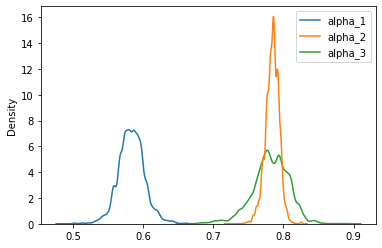

In [ ]:
# sample = trace.sample(1000)
sample = trace

plot_triple_distributions('alpha')

means:
theta_1    4.975061
theta_2    3.034383
theta_3    3.977077
dtype: float64
sigmas:
theta_1    0.028410
theta_2    0.042727
theta_3    0.084304
dtype: float64
actuals: 5 3 4
[4.80994772 4.82806183 4.83958899 4.85440962 4.97132793 4.98120835
 5.09977339 5.11294729] 4.981208347601954
[2.85511642 2.89514426 3.04324726 3.19735444 3.21936975] 3.0432472638304633
[3.47455972 3.55273007 3.58491786 3.6217039  3.65389169 3.75045506
 3.99416262 4.0171539  4.24246843 4.32523703] 3.9941626174717886


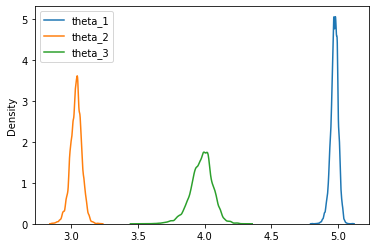

In [ ]:
plot_triple_distributions('theta')

means:
k_1    0.524236
k_2    0.190467
k_3    0.605175
dtype: float64
sigmas:
k_1    0.252667
k_2    0.049273
k_3    0.267780
dtype: float64
actuals: 0.2 0.2 0.2
[0.36400928 0.63038558 0.80162749 0.93481563] 0.3640092837758047
[0.16876126 0.1920972  0.22081836 0.24594937 0.30339169 0.33211284
 0.37160443 0.40032559 0.43443196] 0.1687612626711973
[0.11110233 0.25988558 0.48837413 0.87095963] 0.8709596251548715


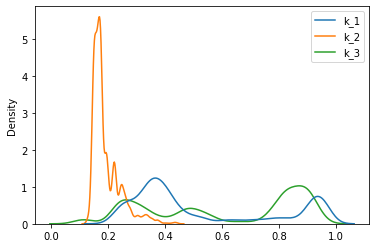

In [ ]:
plot_triple_distributions('k')

means:
s_1    0.783637
s_2    1.555707
s_3    0.952781
dtype: float64
sigmas:
s_1    0.323067
s_2    0.386806
s_3    0.506834
dtype: float64
actuals: 1 2 2
[0.46599908 0.60141873 0.78463356 1.0076777  1.48562943] 0.46599907908152677
[0.76107177 0.93104717 1.50096467 1.79092269 2.23085901] 1.5009646658230231
[0.54010512 0.83252626 1.35379874 1.70978969] 0.5401051208017345


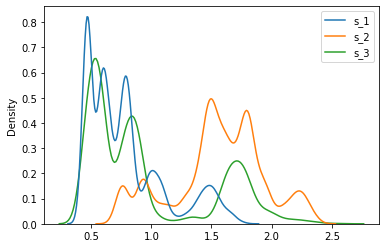

In [ ]:
plot_triple_distributions('s')

means:
beta_1    1.016959
beta_2    0.773515
beta_3    0.604423
dtype: float64
sigmas:
beta_1    0.330877
beta_2    0.148254
beta_3    0.227833
dtype: float64
actuals: 0.8 0.6 0.3
[0.55079135 0.66487308 0.85277239 1.13462137 1.49699862] 1.4969986247323774
[0.51497641 0.61312502 0.68993697 0.82649155 0.9033035  0.9715808
 1.14227402] 0.8264915511044353
[0.28808606 0.56674734 0.75583893 0.88521738 0.93995441] 0.5667473421640415


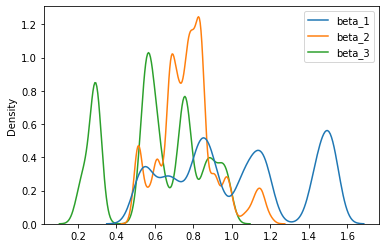

In [ ]:
plot_triple_distributions('beta')

means:
intercept    3.906057
lamb        -0.499711
noise        0.007962
dtype: float64
sigmas:
intercept    0.028710
lamb         0.000723
noise        0.001976
dtype: float64
actuals: (intercept ~ HalfNormal, lamb ~ Normal, 0.0025000000000000005)
[3.85271799 3.86646536 3.88165983 3.91494295 3.94677898] 3.914942948871028


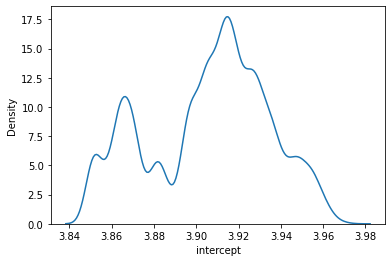

In [ ]:
df = pandas.DataFrame(columns=['intercept','lamb','noise'])
df.intercept = sample['intercept']
df['lamb'] = sample['lamb']
df['noise']= sample['noise']
print(f'means:\n{df.mean()}')
print(f'sigmas:\n{df.std()}')
print(f'actuals: {ru, lamb, ep}')
plot = sns.kdeplot(data=df.intercept, common_norm=True)
print_peaks(plot)

[-0.50305162 -0.50277083 -0.49992275 -0.49944139 -0.4988798  -0.49791707
 -0.49667354 -0.49615207 -0.49559048] -0.4999227539830357


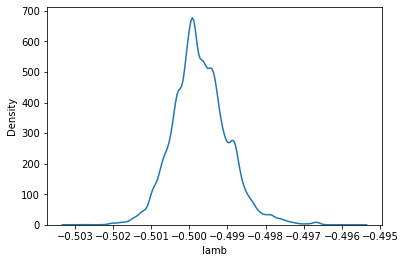

In [ ]:
plot = sns.kdeplot(data=df.lamb, common_norm=True)
print_peaks(plot)

[0.00657415 0.00703105 0.01053389 0.01624506 0.01738729 0.01852952] 0.007031046403962975


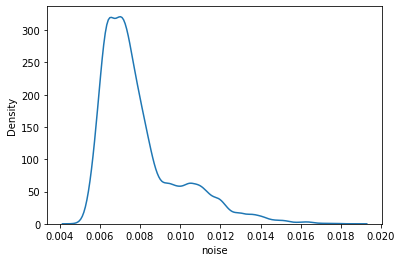

In [ ]:
plot = sns.kdeplot(data=df.noise, common_norm=True)
print_peaks(plot)